In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
hyper_parm= {'learning_rate':0.001,'epochs':10,'batch_size':256}
hyper_parm['epochs']

10

In [0]:
# reading the data
import pandas as pd
import numpy as np
df = pd.read_csv('/content/drive/My Drive/bq-results-20191230-232257-dxz7o9g89anp/bq-results-20191230-232257-dxz7o9g89anp.csv')
df.head()

,domain,title
0,github.com,Introducing AwesomeLog!
1,github.com,Show HN: Metastream – P2P Electron app to watc...
2,github.com,Show HN: Shorty – A dead simple URL shortener ...
3,github.com,Show HN: Tech Companies Logo Made with Pure CSS
4,github.com,FileKit: An open source end-to-end encrypted c...


In [0]:
tmp=np.random.shuffle(np.array(df))

In [0]:
#count of each classes
df.groupby('domain').count()

,title
domain,
github.com,42114
medium.com,53348
techcrunch.com,11546


In [0]:
#dropping missing values, if any
df=df.dropna()

In [0]:
#embedding the classes
df=df.replace({'domain':{'github.com': 0, 'medium.com': 1, 'techcrunch.com': 2}})

In [0]:
#splitting data into train, validate, test dataset
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test= train_test_split(df['title'],df['domain'],test_size=0.3,random_state= 42)
x_val,x_test,y_val,y_test= train_test_split(x_test,y_test,test_size=0.5,random_state= 42)

In [0]:
import re 
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [0]:
replace_with_nospace= re.compile("[.;:![\w-][\w:]\'?,\"()\[\]]")
replace_with_space=re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
english_stopwords= stopwords.words('english')
def pre_process(para):
    corpus=[]
    for line in para:
      corpus.append(line.strip())
    corpus=[replace_with_nospace.sub("",line.lower()) for line in corpus]
    corpus=[replace_with_space.sub(" ",line) for line in corpus]
    corpus=[(' '.join([word for word in line.split() if word not in english_stopwords])) for line in corpus] 
    lemmater= WordNetLemmatizer()   
    corpus=[' '.join([lemmater.lemmatize(word) for word in line.split()])for line in corpus]
    return corpus

In [0]:
title_train=pre_process(x_train)
title_val=pre_process(x_val)
title_test=pre_process(x_test)

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorize= TfidfVectorizer()
vectorize.fit(title_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [0]:
title_train=vectorize.transform(title_train)
title_val=vectorize.transform(title_val)
title_test=vectorize.transform(title_test)

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
model= LogisticRegression().fit(title_train,y_train)
print("Final Accuracy: %s" % accuracy_score(y_val, model.predict(title_val)))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Final Accuracy: 0.8069279172637219


In [0]:
from sklearn.svm import LinearSVC
model= LinearSVC().fit(title_train,y_train)
print("Final Accuracy: %s" % accuracy_score(y_val, model.predict(title_val)))

Final Accuracy: 0.814217182730048


In [0]:
len(CLASSES)

3

In [0]:
from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.preprocessing import text

# Vectorization parameters
# Limit on the number of features. We use the top 20K features.
TOP_K = 20000
CLASSES = {'github.com': 0, 'medium.com': 1, 'techcrunch.com': 2} 
# Limit on the length of text sequences. Sequences longer than this
# will be truncated.
MAX_SEQUENCE_LENGTH = 50

def sequence_vectorize(train_texts, val_texts):
   
    # Create vocabulary with training texts.
    tokenizer = text.Tokenizer(num_words=TOP_K)
    tokenizer.fit_on_texts(train_texts)

    # Vectorize training and validation texts.
    x_train = tokenizer.texts_to_sequences(train_texts)
    x_val = tokenizer.texts_to_sequences(val_texts)

    x_train = sequence.pad_sequences(x_train, maxlen=MAX_SEQUENCE_LENGTH)
    x_val = sequence.pad_sequences(x_val, maxlen=MAX_SEQUENCE_LENGTH)
    return x_train, x_val, tokenizer.word_index

In [0]:
len(word_index)

46396

In [0]:
x_train, x_val, word_index=sequence_vectorize(x_train,x_val)

In [0]:
x_val[1].shape

(50,)

In [0]:
filters=64
dropout_rate=0.2
embedding_dim=200
kernel_size=3
pool_size=3
import tensorflow as tf
from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.preprocessing import text
from tensorflow.python.keras import models
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.layers import Embedding
from tensorflow.python.keras.layers import Conv1D
from tensorflow.python.keras.layers import MaxPooling1D
from tensorflow.python.keras.layers import GlobalAveragePooling1D
num_features = min(len(word_index) + 1, TOP_K)
model = models.Sequential()
model.add(Embedding(input_dim=num_features,
                            output_dim=200,
                            input_length=MAX_SEQUENCE_LENGTH))
 
model.add(Dropout(rate=dropout_rate))
model.add(Conv1D(filters=filters,
                            kernel_size=kernel_size,
                            activation='relu',
                            bias_initializer='random_uniform',
                            padding='same'))

model.add(MaxPooling1D(pool_size=pool_size))
model.add(Conv1D(filters=filters * 2,
                            kernel_size=kernel_size,
                            activation='relu',
                            bias_initializer='random_uniform',
                            padding='same'))
model.add(GlobalAveragePooling1D())
model.add(Dropout(rate=dropout_rate))
model.add(Dense(len(CLASSES), activation='softmax'))


In [0]:
optimizer = tf.keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['acc'])

In [0]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience=2)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
callbacks=[earlystop,learning_rate_reduction]

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 200)           4000000   
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 200)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 50, 64)            38464     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 16, 64)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 16, 128)           24704     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 128)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)              

In [0]:
batch_size=512
history = model.fit(
    x_train,
    y_train,
    epochs=10,
    validation_data=(x_val,y_val),
    callbacks=callbacks,
    batch_size=512
)

Train on 74905 samples, validate on 16051 samples
Epoch 1/10
74905/74905 [==============================] - 46s 613us/sample - loss: 0.7663 - acc: 0.6574 - val_loss: 0.5553 - val_acc: 0.7747
Epoch 2/10
74905/74905 [==============================] - 46s 613us/sample - loss: 0.4453 - acc: 0.8233 - val_loss: 0.4458 - val_acc: 0.8233
Epoch 3/10
74905/74905 [==============================] - 46s 611us/sample - loss: 0.3522 - acc: 0.8641 - val_loss: 0.4439 - val_acc: 0.8248
Epoch 4/10
74905/74905 [==============================] - 46s 614us/sample - loss: 0.2973 - acc: 0.8878 - val_loss: 0.4566 - val_acc: 0.8252
Epoch 5/10
74905/74905 [==============================] - 46s 610us/sample - loss: 0.2536 - acc: 0.9073 - val_loss: 0.4860 - val_acc: 0.8221


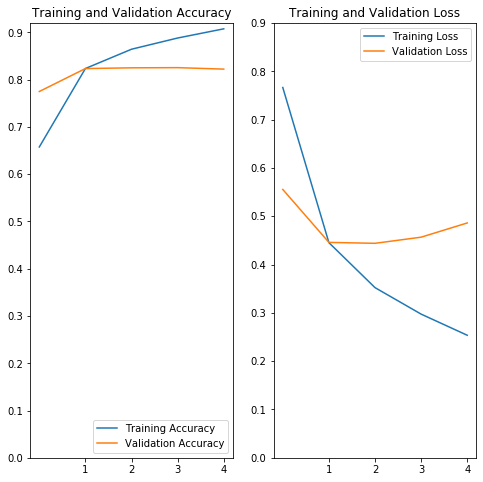

In [0]:
import matplotlib.pyplot as plt
epochs=5
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xticks(np.arange(1, epochs, 1))
plt.yticks(np.arange(0, 1, 0.1))
plt.legend(loc='lower right')

plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xticks(np.arange(1, epochs, 1))
plt.yticks(np.arange(0, 1, 0.1))
plt.title('Training and Validation Loss')
plt.show()